# Imports

In [73]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Config

In [74]:
INPUT_PATH = 'ride_data/'
OUTPUT_PATH = 'data/pair_labels.parquet'
START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

# Loading Dataset

In [75]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path) 
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'DOLocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [76]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)
print(f'rides_df shape : {rides_df.shape}')
rides_df.head()

rides_df shape : (12672629, 4)


,tpep_pickup_datetime,PULocationID,DOLocationID,PU_date
0,2023-01-01 00:32:10,161,141,2023-01-01
1,2023-01-01 00:55:08,43,237,2023-01-01
2,2023-01-01 00:25:04,48,238,2023-01-01
3,2023-01-01 00:03:48,138,7,2023-01-01
4,2023-01-01 00:10:29,107,79,2023-01-01


# Labeling

In [77]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'DOLocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'DOLocationID', 'PU_date'], ascending=[True, True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'PULocation', 'DOLocationID': 'DOLocation', 'PU_date': 'Date'})
    )
  
    pu_locations = pd.DataFrame(dataset_labels['PULocation'].unique(), columns=['PULocation'])
    do_locations = pd.DataFrame(dataset_labels['DOLocation'].unique(), columns=['DOLocation'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])
    
    location_date_df = (
        pu_locations
        .merge(dates, how='cross')
        .merge(do_locations, how = 'cross')
        .sort_values(['PULocation', 'DOLocation', 'Date'], ascending=[True, True, True])
        .reset_index(drop=True)
    )
    
    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['PULocation', 'DOLocation', 'Date'])
        .fillna(value=0)
    )
    
    return labels_df

In [78]:
labels_df = labeling(rides_df)
print(f'labels_df shape : {labels_df.shape}')
labels_df.head()

labels_df shape : (8205840, 4)


,PULocation,Date,DOLocation,Demand
0,1,2023-01-01,1,37.0
1,1,2023-01-02,1,29.0
2,1,2023-01-03,1,25.0
3,1,2023-01-04,1,6.0
4,1,2023-01-05,1,11.0


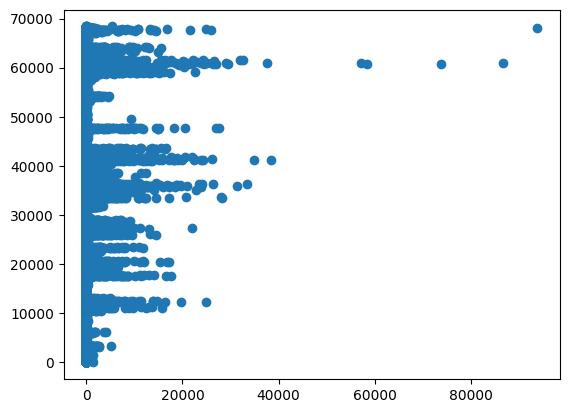

In [79]:
plt.scatter(labels_df.groupby(['PULocation', 'DOLocation'])['Demand'].sum().values, range(68382))

In [89]:
important_pairs = (labels_df.groupby(['PULocation', 'DOLocation'], as_index=False)['Demand']
                   .sum().sort_values('Demand', ascending=False)
                   .reset_index(drop=True)[:5][['PULocation', 'DOLocation']])
merged_df = pd.merge(labels_df, important_pairs, on=['PULocation', 'DOLocation'], how='inner')

# File saving

In [90]:
def save_labels(dataset, path):
    labels_df = dataset.to_parquet(path, index=False)

In [91]:
save_labels(merged_df, OUTPUT_PATH)